# 데이터의 독립성 판단 및 실험

In [132]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import plot_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.rcParams["font.family"]='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [167]:
train_activity = pd.read_csv('train_activity.csv')
train_sleep = pd.read_csv('train_sleep.csv')
train_mmse = pd.read_csv('train_mmse.csv')

training_label = pd.read_csv('training_label_activity.csv')

In [168]:
val_activity = pd.read_csv('val_activity.csv')
val_sleep = pd.read_csv('val_sleep.csv')

val_label = pd.read_csv('val_label_activity.csv')

In [169]:
def preprocessing(train, label):
    drop_cols = train.describe(include = 'O').columns[1:]
    train = train.drop(drop_cols, axis = 1)
    data = train.groupby('EMAIL').mean().reset_index()
    labeling = dict(np.array(label))

    data['target'] = data['EMAIL'].map(labeling)
    train['target'] = train['EMAIL'].map(labeling)

    # target 변수 numerical data로 변환
    target_dict = {"CN": 0, "MCI": 0, "Dem": 1}
    data['target'] = data['target'].map(target_dict)
    data = data.sort_values(by=['target','EMAIL'], ascending=[True,True])
    data = data.reset_index(drop=True)
    
    train['target'] = train['target'].map(target_dict)
    train = train.sort_values(by=['target','EMAIL'], ascending=[True,True])
    train = train.reset_index(drop=True)

    # Step 1: 'number' 열을 생성 (EMAIL에서 숫자만 추출)
    data['number'] = data['EMAIL'].str.extract(r'(?<=nia\+)(\d+)', expand=False).astype(int)
    train['number'] = train['EMAIL'].str.extract(r'(?<=nia\+)(\d+)', expand=False).astype(int)

    # Step 2: EMAIL 열 삭제
    data.drop(columns=['EMAIL'], inplace=True)
    train.drop(columns=['EMAIL'], inplace=True)

    return data, train

_, train_activity = preprocessing(train_activity, training_label)


In [170]:
_, train_sleep = preprocessing(train_sleep, training_label)

In [171]:
_, val_activity = preprocessing(val_activity, val_label)
_, val_sleep = preprocessing(val_sleep, val_label)
test = pd.concat([val_activity, val_sleep.loc[:, ~val_sleep.columns.isin(val_activity.columns)]], axis=1)

- 데이터의 왜도 체크

In [172]:
from scipy.stats import skew
skewness = train_activity.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness)

Skewness for each column:
activity_average_met                 0.960751
activity_cal_active                  1.241112
activity_cal_total                   0.562600
activity_daily_movement              1.196831
activity_high                        7.406129
activity_inactive                    0.180745
activity_inactivity_alerts           2.105201
activity_low                         0.479395
activity_medium                      1.313342
activity_met_min_high                9.167017
activity_met_min_inactive            1.190537
activity_met_min_low                 1.078192
activity_met_min_medium              1.651317
activity_non_wear                    1.556458
activity_rest                        0.519608
activity_score                      -0.987259
activity_score_meet_daily_targets   -1.115499
activity_score_move_every_hour      -4.270279
activity_score_recovery_time        -2.222640
activity_score_stay_active          -0.802809
activity_score_training_frequency   -1.558001
activity

In [173]:
skewness.values

array([ 0.9607514 ,  1.24111211,  0.56260049,  1.19683106,  7.40612926,
        0.18074528,  2.10520094,  0.47939525,  1.31334208,  9.1670165 ,
        1.1905365 ,  1.07819161,  1.65131668,  1.55645834,  0.51960833,
       -0.98725898, -1.11549905, -4.27027881, -2.22264005, -0.80280939,
       -1.55800109, -1.89189264,  0.92313637,  0.38331421,  3.74953478,
        0.04389677])

In [174]:
activity_cols_log = list(skewness[skewness.values>0.5].index)
activity_cols_log.remove('target')

In [175]:
# 0.5 이상은 왜도가 높은 -> 로그 변환으로 왜도 해소 시도
def log_transform(df, columns):
    for col in columns:
        # 1을 더한 후 Log Transformation 적용
        df[col] = np.log1p(df[col])

    return df

# 주어진 열에 Log Transformation 적용
df = log_transform(train_activity, activity_cols_log)

In [176]:
# 모든 열의 왜도 확인
skewness = df.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness)

Skewness for each column:
activity_average_met                 0.255714
activity_cal_active                 -1.037833
activity_cal_total                  -0.049029
activity_daily_movement             -1.399139
activity_high                        0.926930
activity_inactive                    0.180745
activity_inactivity_alerts           1.220707
activity_low                         0.479395
activity_medium                     -1.048599
activity_met_min_high                0.297805
activity_met_min_inactive           -0.376528
activity_met_min_low                -0.923463
activity_met_min_medium             -1.337566
activity_non_wear                    0.231480
activity_rest                       -2.131355
activity_score                      -0.987259
activity_score_meet_daily_targets   -1.115499
activity_score_move_every_hour      -4.270279
activity_score_recovery_time        -2.222640
activity_score_stay_active          -0.802809
activity_score_training_frequency   -1.558001
activity

In [177]:
skewness[skewness.values>0.5].index

Index(['activity_high', 'activity_inactivity_alerts', 'target'], dtype='object')

In [178]:
# 주어진 열들에 대해 0이나 음수값이 있는지 확인
columns_to_check = ['activity_high', 'activity_inactivity_alerts']

for col in columns_to_check:
    has_zero_or_negative = (df[col] <= 0).any()
    if has_zero_or_negative:
        print(f"{col} 열에 0이나 음수값이 존재합니다.")
    else:
        print(f"{col} 열에 0이나 음수값이 없습니다.")

activity_high 열에 0이나 음수값이 존재합니다.
activity_inactivity_alerts 열에 0이나 음수값이 존재합니다.


In [179]:
train_activity = df

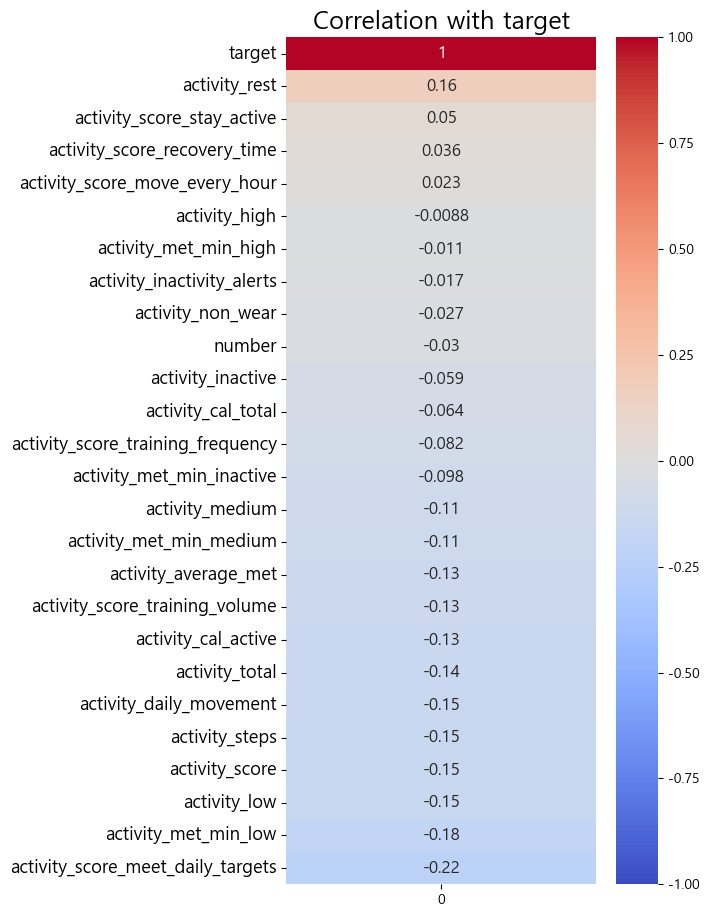

In [180]:
# 문자열 열을 제외하고 숫자형 열만 선택
numeric_df = df.select_dtypes(include=[np.number])

# target과 다른 숫자형 변수들 간의 상관계수 계산
correlation_matrix = numeric_df.corr()

# target과 다른 변수들과의 상관계수만 선택
target_correlation = correlation_matrix['target'].sort_values(ascending=False)

# 상관관계 시각화를 위해 NumPy 배열로 변환
target_correlation_array = target_correlation.values.reshape(-1, 1)

# 상관관계 시각화
plt.figure(figsize=(5, 11))
sns.heatmap(target_correlation_array, annot=True, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=target_correlation.index, annot_kws={"size": 12})
plt.yticks(fontsize=13)
plt.title("Correlation with target", fontsize=18)
plt.show()

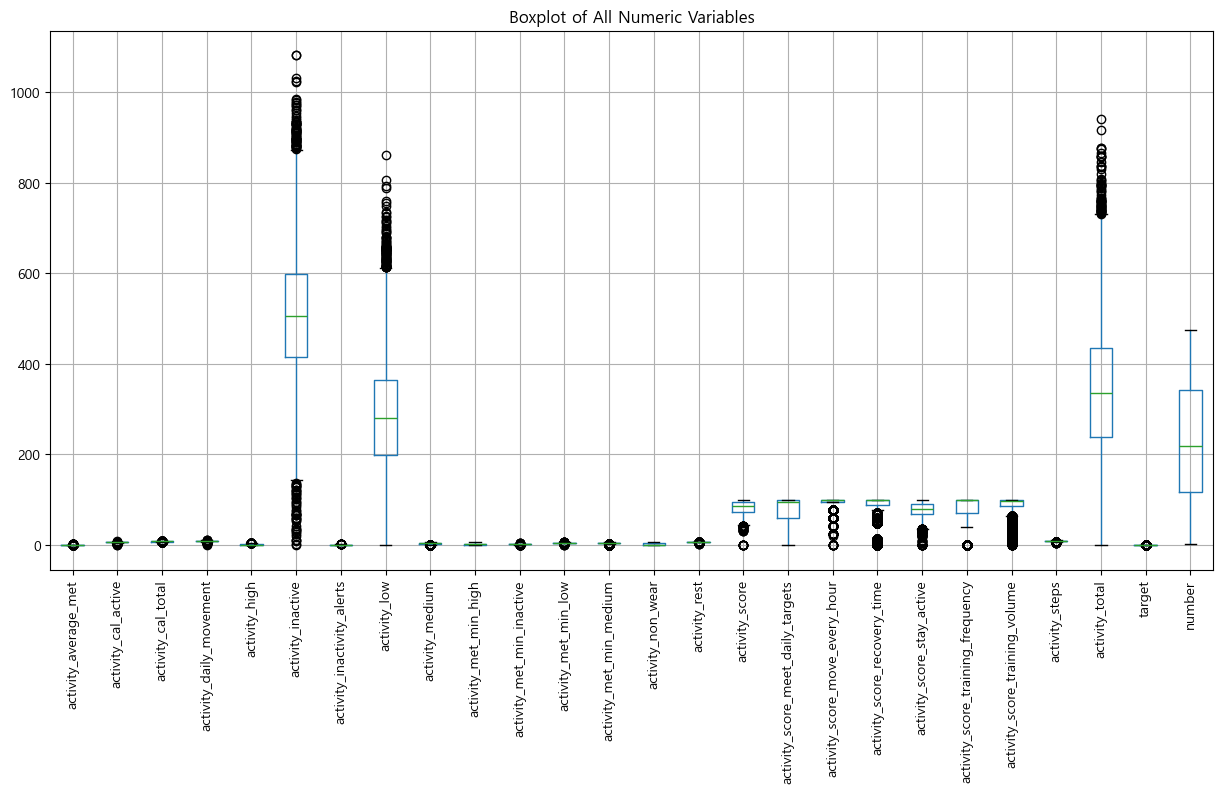

In [181]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_activity.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

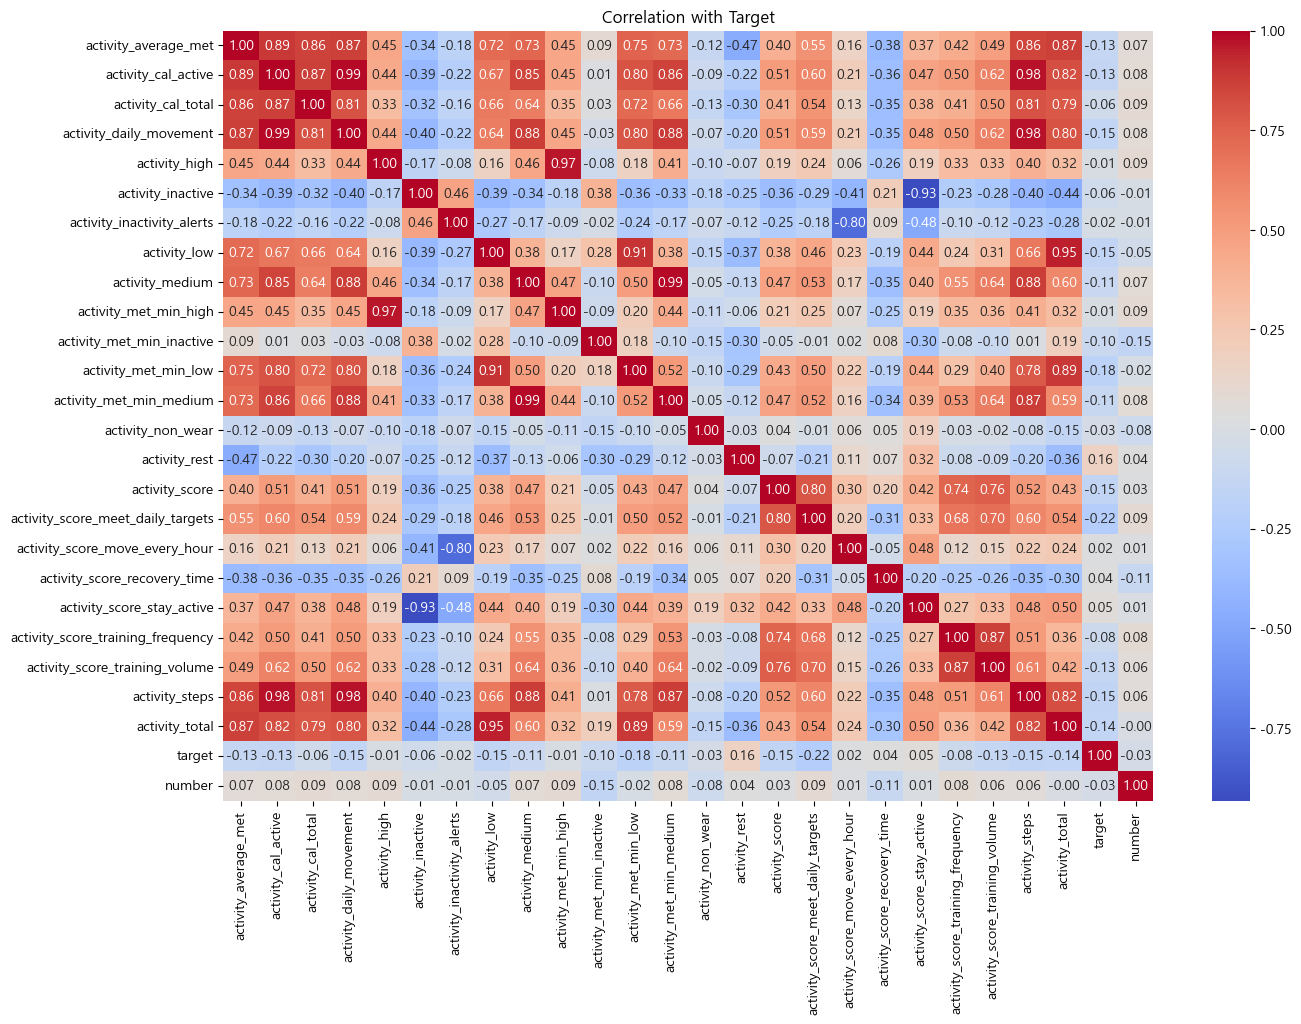

In [182]:
# correlatino으로 variable select
correlation_activity = train_activity.copy()

plt.figure(figsize=(15,10))
sns.heatmap(correlation_activity.corr(), annot=True, fmt='.2f',cmap='coolwarm')
plt.title('Correlation with Target')
plt.show()

In [183]:
from scipy.stats import skew
skewness_sleep = train_sleep.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness_sleep)

Skewness for each column:
sleep_awake                    1.537876
sleep_breath_average          -0.183781
sleep_deep                     0.523582
sleep_duration                 0.516258
sleep_efficiency              -0.831787
sleep_hr_average               0.222999
sleep_hr_lowest                0.270056
sleep_is_longest                    NaN
sleep_light                    0.471835
sleep_midpoint_at_delta        3.946977
sleep_midpoint_time            0.834369
sleep_onset_latency            4.285766
sleep_period_id                1.297660
sleep_rem                      0.441750
sleep_restless                 0.459600
sleep_rmssd                    2.353779
sleep_score                   -0.548432
sleep_score_alignment         -2.420322
sleep_score_deep              -1.411289
sleep_score_disturbances      -0.043193
sleep_score_efficiency        -0.861214
sleep_score_latency           -1.773915
sleep_score_rem               -0.071837
sleep_score_total             -0.436557
sleep_temperat

In [184]:
sleep_cols_log = list(skewness_sleep[skewness_sleep.values>0.5].index)
sleep_cols_log.remove('target')
sleep_cols_log.remove('sleep_midpoint_at_delta')

In [185]:
# 주어진 열에 Log Transformation 적용
df = log_transform(train_sleep, sleep_cols_log)

In [186]:
# 모든 열의 왜도 확인
skewness_sleep = df.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness_sleep)

Skewness for each column:
sleep_awake                   -0.166364
sleep_breath_average          -0.183781
sleep_deep                    -2.278488
sleep_duration                -0.330791
sleep_efficiency              -0.831787
sleep_hr_average               0.222999
sleep_hr_lowest                0.270056
sleep_is_longest                    NaN
sleep_light                    0.471835
sleep_midpoint_at_delta        3.946977
sleep_midpoint_time           -0.201391
sleep_onset_latency           -0.518677
sleep_period_id                0.494600
sleep_rem                      0.441750
sleep_restless                 0.459600
sleep_rmssd                    0.550118
sleep_score                   -0.548432
sleep_score_alignment         -2.420322
sleep_score_deep              -1.411289
sleep_score_disturbances      -0.043193
sleep_score_efficiency        -0.861214
sleep_score_latency           -1.773915
sleep_score_rem               -0.071837
sleep_score_total             -0.436557
sleep_temperat

In [187]:
skewness_sleep[skewness_sleep.values>0.5].index

Index(['sleep_midpoint_at_delta', 'sleep_rmssd', 'target'], dtype='object')

In [188]:
train_sleep = df

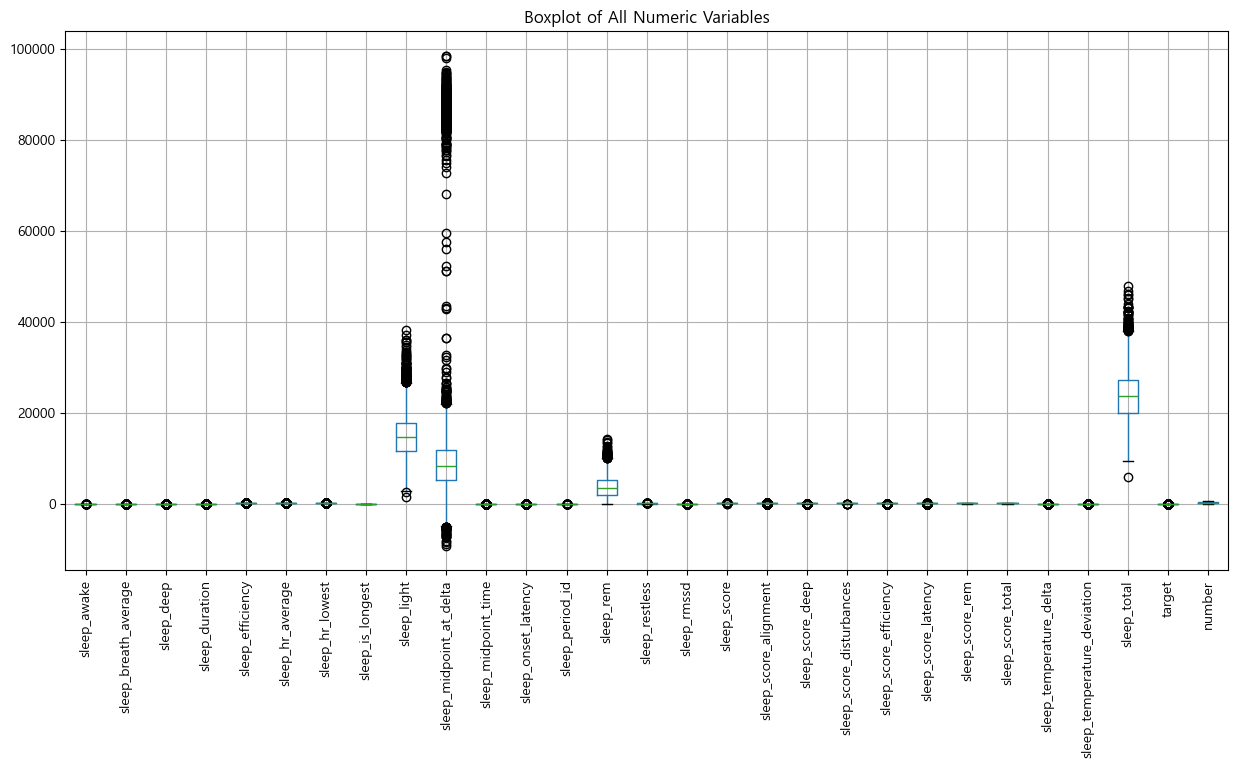

In [189]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_sleep.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

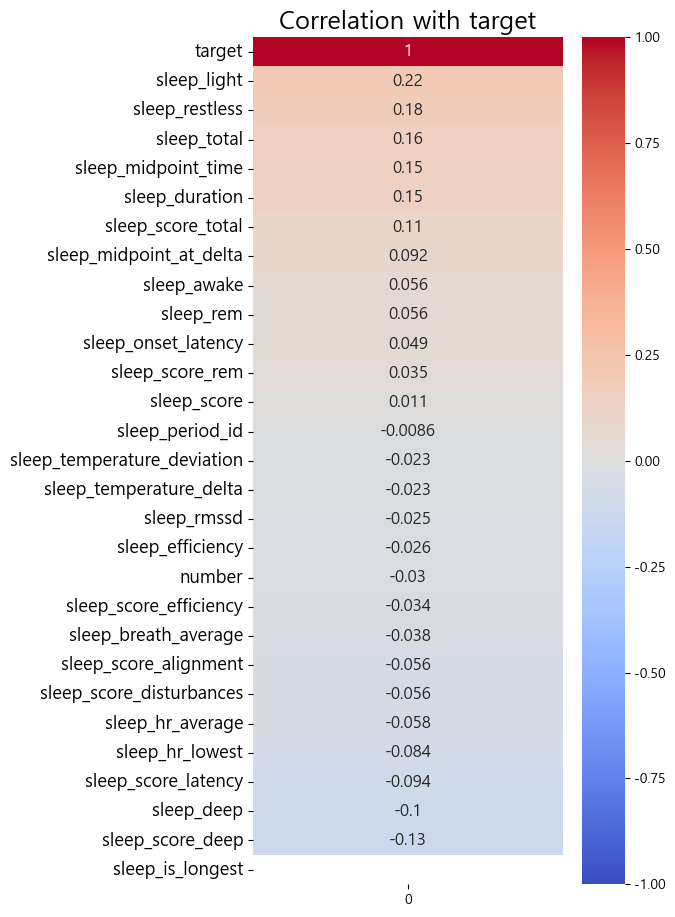

In [190]:
# 문자열 열을 제외하고 숫자형 열만 선택
numeric_df = df.select_dtypes(include=[np.number])

# target과 다른 숫자형 변수들 간의 상관계수 계산
correlation_matrix = numeric_df.corr()

# target과 다른 변수들과의 상관계수만 선택
target_correlation = correlation_matrix['target'].sort_values(ascending=False)

# 상관관계 시각화를 위해 NumPy 배열로 변환
target_correlation_array = target_correlation.values.reshape(-1, 1)

# 상관관계 시각화
plt.figure(figsize=(5, 11))
sns.heatmap(target_correlation_array, annot=True, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=target_correlation.index, annot_kws={"size":12})
plt.yticks(fontsize=13)
plt.title("Correlation with target", fontsize=18)
plt.show()

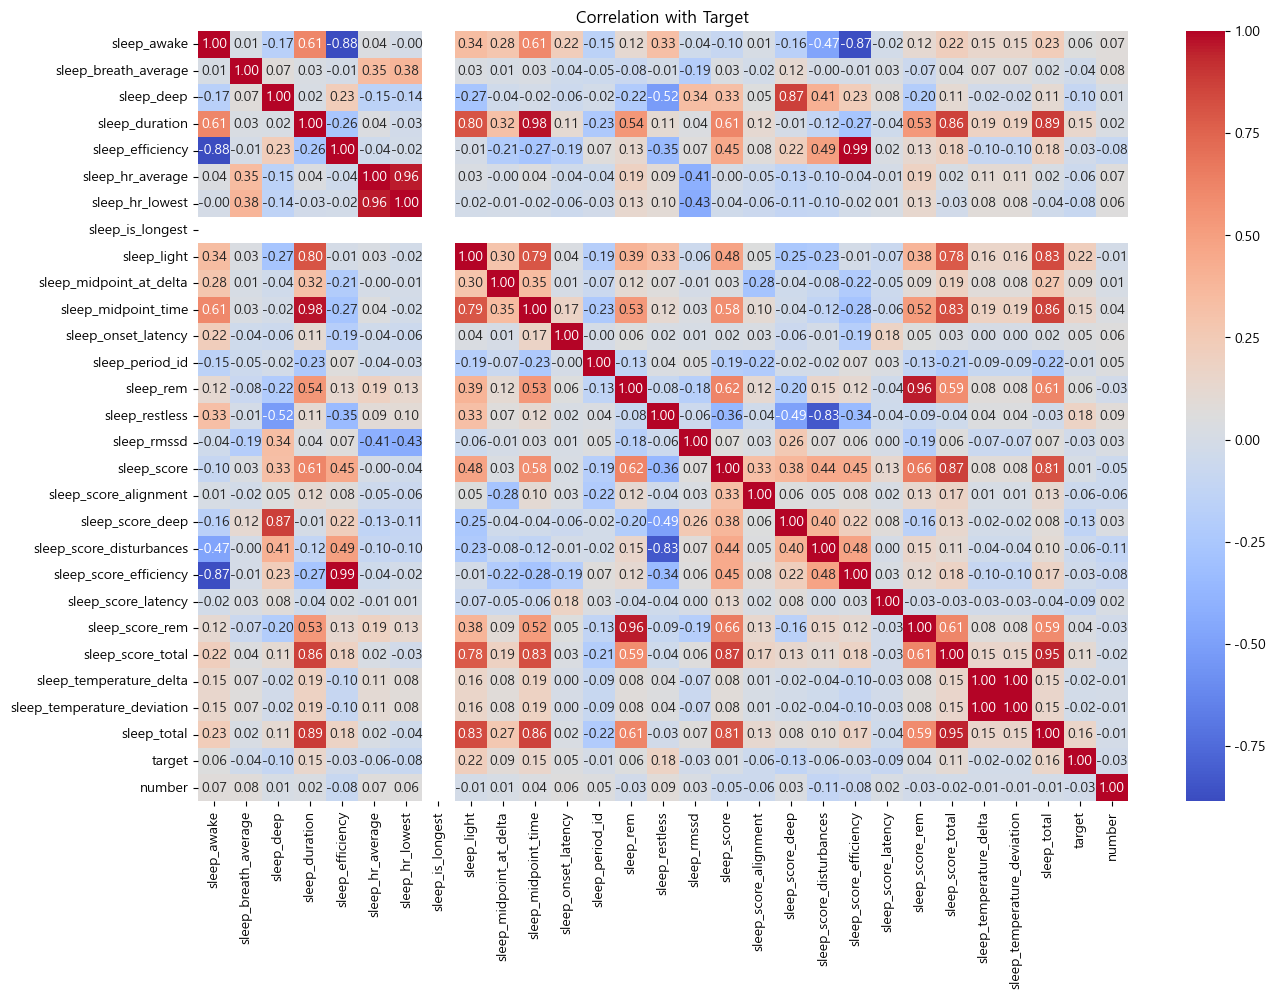

In [191]:
# correlatino으로 variable select
correlation_activity = train_sleep.copy()

plt.figure(figsize=(15,10))
sns.heatmap(correlation_activity.corr(), annot=True, fmt='.2f',cmap='coolwarm')
plt.title('Correlation with Target')
plt.show()

In [192]:
train = pd.concat([train_activity, train_sleep.loc[:, ~train_sleep.columns.isin(train_activity.columns)]], axis=1)

In [193]:
for col in activity_cols_log:
    test[col] = np.log1p(test[col].clip(lower=0))

for col in sleep_cols_log:
    test[col] = np.log1p(test[col].clip(lower=0))

실험 1. activity data로 학습

                              Feature  Importance
14                      activity_rest    0.083919
21     activity_score_training_volume    0.068574
7                        activity_low    0.056464
3             activity_daily_movement    0.056186
11               activity_met_min_low    0.054210
2                  activity_cal_total    0.053624
1                 activity_cal_active    0.051698
22                     activity_steps    0.049837
23                     activity_total    0.049680
15                     activity_score    0.049172
12            activity_met_min_medium    0.047602
5                   activity_inactive    0.047153
16  activity_score_meet_daily_targets    0.046235
19         activity_score_stay_active    0.042371
8                     activity_medium    0.041538
10          activity_met_min_inactive    0.034364
9               activity_met_min_high    0.033636
0                activity_average_met    0.033415
13                  activity_non_wear    0.027038


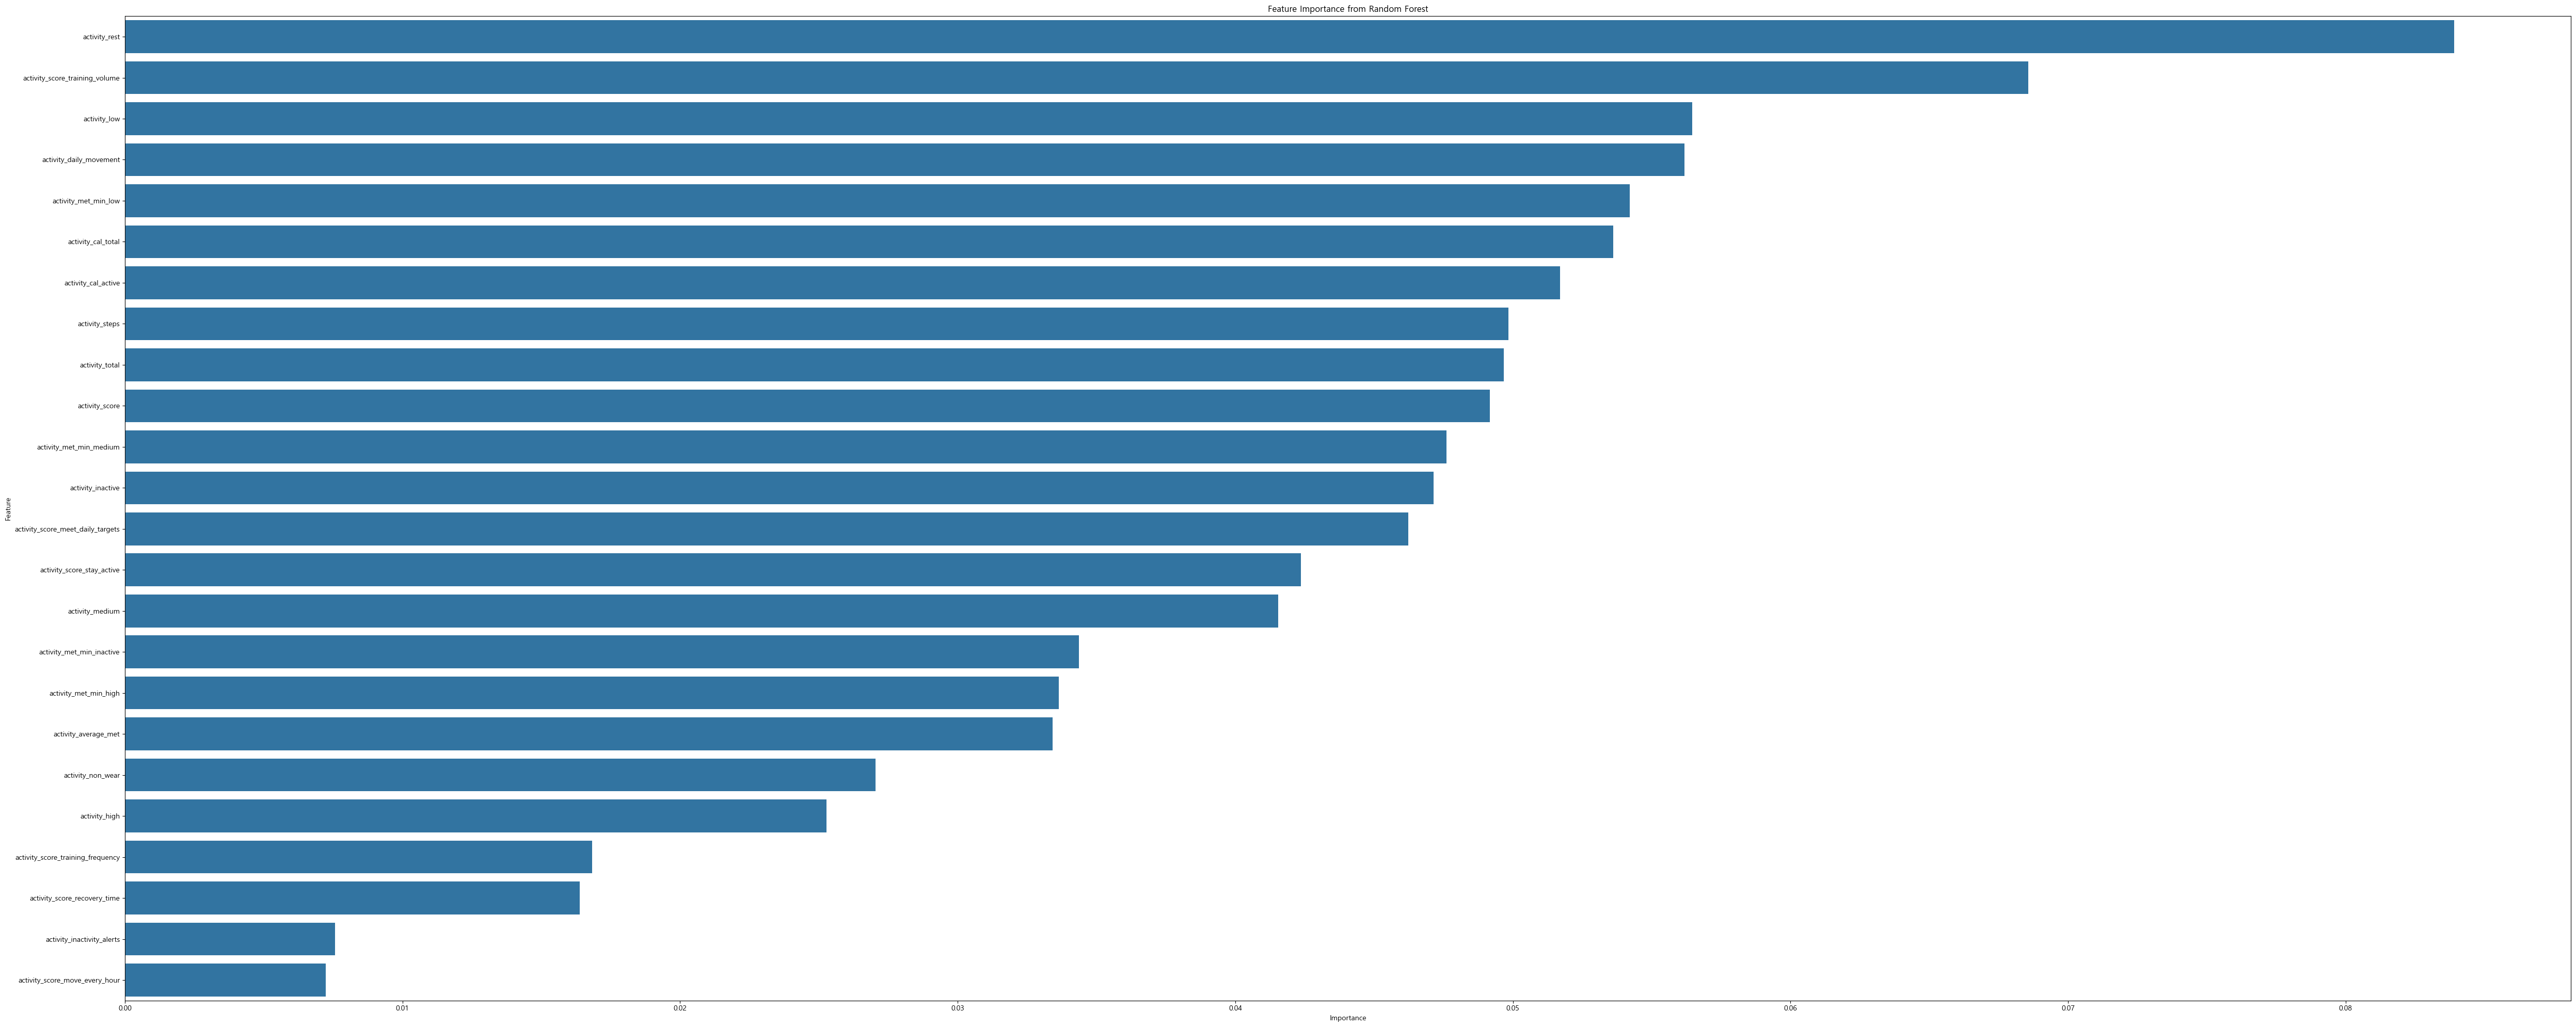

Validation Accuracy: 0.91


In [194]:
# DIAG_NM을 종속 변수로 설정하고 독립 변수와 분리
X_train = train_activity.drop(columns=['target', 'number'])
y_train = train_activity['target']

# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# 중요한 피처 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

# 시각화
plt.figure(figsize=(50, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 검증 데이터로 예측 정확도 확인 (선택 사항)
X_val = val_activity.drop(columns=['target', 'number'])
y_val = val_activity['target']
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

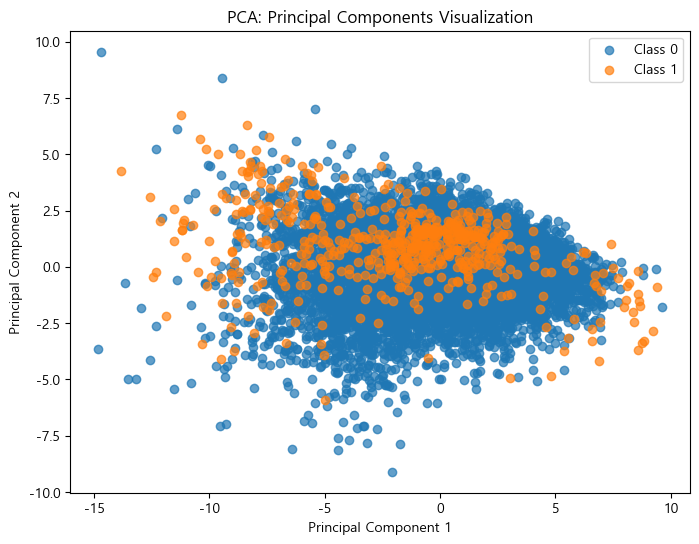

Explained Variance Ratio: [0.45110217 0.11215227]


In [195]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [196]:
top_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_features)

Top 10 Features: ['activity_rest', 'activity_score_training_volume', 'activity_low', 'activity_daily_movement', 'activity_met_min_low', 'activity_cal_total', 'activity_cal_active', 'activity_steps', 'activity_total', 'activity_score']


In [197]:
X_train = train_activity[top_features]
y_train = train_activity["target"]
X_test = val_activity[top_features]
y_test = val_activity["target"]

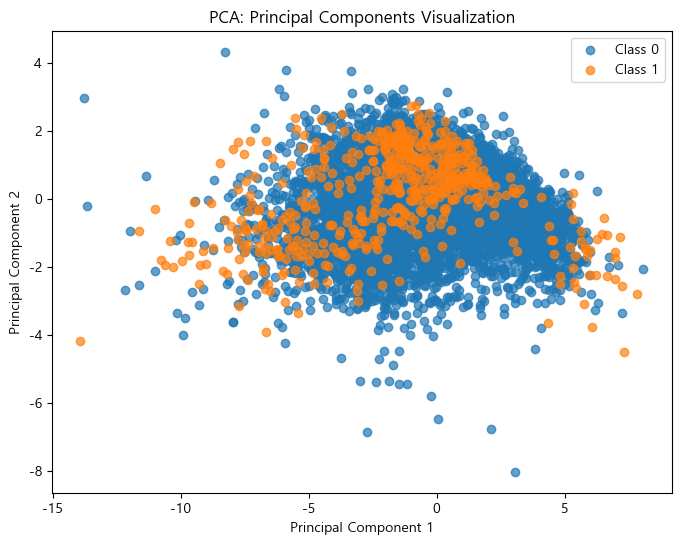

Explained Variance Ratio: [0.66661199 0.13223858]


In [198]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

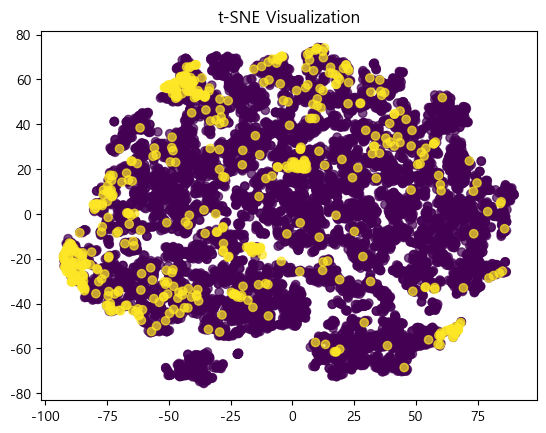

In [199]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.show()

In [200]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.189589
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9694
Method:                           MLE   Df Model:                           10
Date:                Sun, 01 Dec 2024   Pseudo R-squ.:                  0.1527
Time:                        13:14:00   Log-Likelihood:                -1840.0
converged:                       True   LL-Null:                       -2171.5
Covariance Type:            nonrobust   LLR p-value:                5.223e-136
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -69.2897     11.823     -5.860     

- 로직스틱 회귀

In [201]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.9192897497982244
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      2264
           1       0.82      0.08      0.15       214

    accuracy                           0.92      2478
   macro avg       0.87      0.54      0.56      2478
weighted avg       0.91      0.92      0.89      2478

Confusion Matrix:
 [[2260    4]
 [ 196   18]]


- 나이브 베이즈

In [203]:
# 나이브 베이즈 모델 학습
#from sklearn.naive_bayes import ComplementNB
#nb_model = ComplementNB()
nb_model = GaussianNB()
sc = StandardScaler()
X_train_forNB = sc.fit_transform(X_train)
X_test_forNB = sc.transform(X_test)

nb_model.fit(X_train_forNB, y_train)

# 예측
y_pred_nb = nb_model.predict(X_test_forNB)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.08635996771589992
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2264
           1       0.09      1.00      0.16       214

    accuracy                           0.09      2478
   macro avg       0.04      0.50      0.08      2478
weighted avg       0.01      0.09      0.01      2478

Confusion Matrix:
 [[   0 2264]
 [   0  214]]


- XGBoost

In [204]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9100080710250201
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      2264
           1       0.09      0.00      0.01       214

    accuracy                           0.91      2478
   macro avg       0.50      0.50      0.48      2478
weighted avg       0.84      0.91      0.87      2478

Confusion Matrix:
 [[2254   10]
 [ 213    1]]


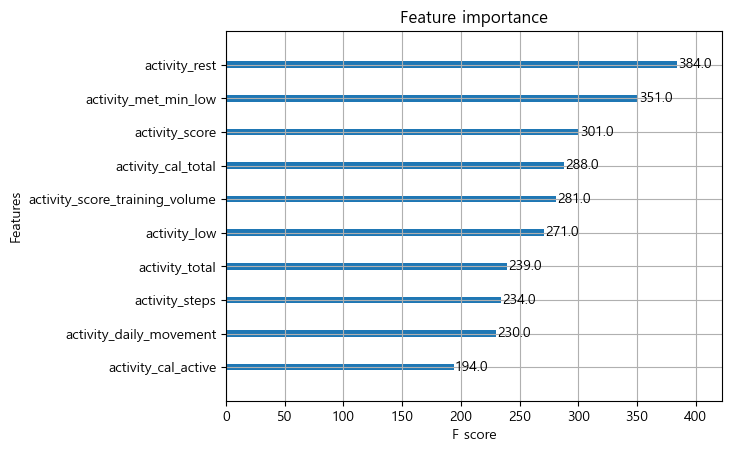

In [205]:
plot_importance(xgb_model)
plt.show()

- LightGBM

In [206]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm_model.fit(X_train, y_train)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 571, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2205
[LightGBM] [Info] Number of data points in the train set: 9705, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.9180790960451978
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      2264
           1       0.53      0.45      0.49       214

    accuracy                           0.92      2478
   macro avg       0.74      0.71      0.72      2478
weighted avg       0.91      0.92      0.91      2478

Confusion Matrix:
 [[2179   85]
 [ 118   96]]


- Decision Tree

In [207]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8890234059725585
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      2264
           1       0.02      0.00      0.01       214

    accuracy                           0.89      2478
   macro avg       0.46      0.49      0.47      2478
weighted avg       0.83      0.89      0.86      2478

Confusion Matrix:
 [[2202   62]
 [ 213    1]]


2. sleep data로 학습

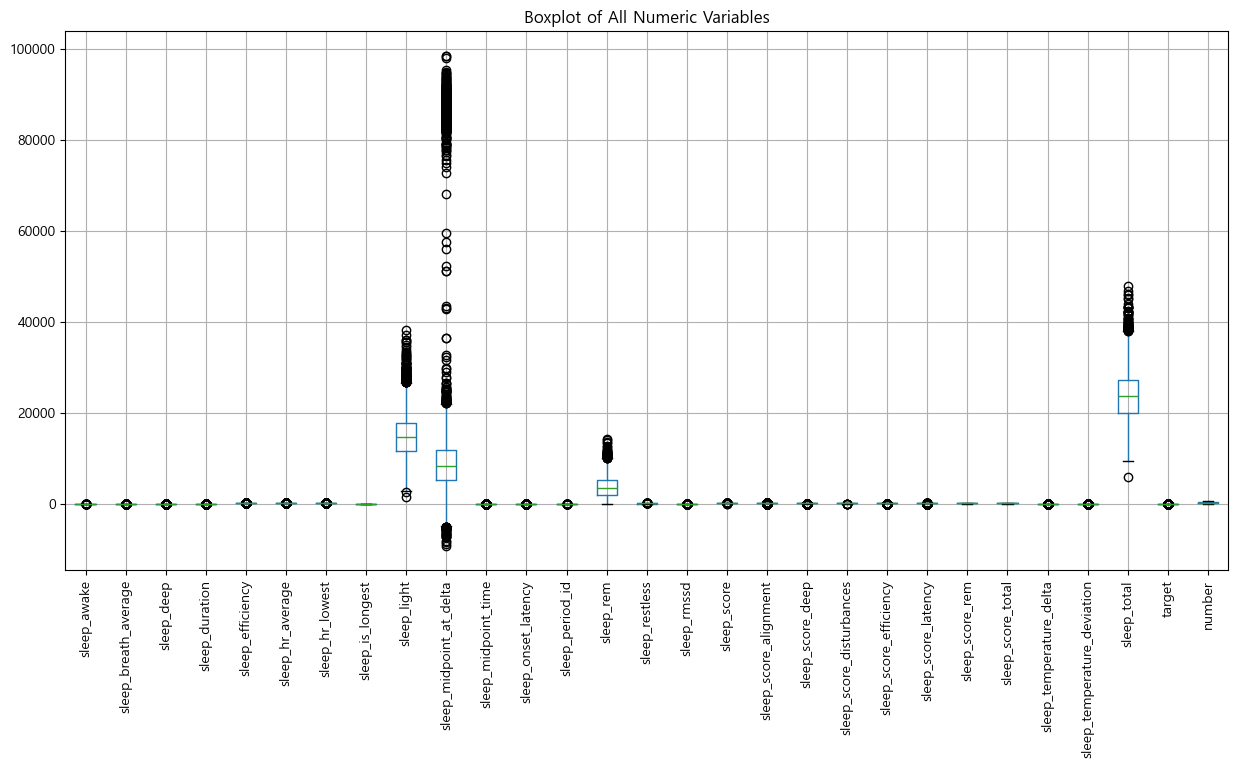

In [38]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_sleep.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

                        Feature  Importance
6               sleep_hr_lowest    0.069417
5              sleep_hr_average    0.063380
24                  sleep_total    0.062218
12               sleep_restless    0.060632
1          sleep_breath_average    0.059164
17     sleep_score_disturbances    0.055974
13                  sleep_rmssd    0.049151
8           sleep_midpoint_time    0.046114
3                sleep_duration    0.042652
2                    sleep_deep    0.041962
11                    sleep_rem    0.039526
0                   sleep_awake    0.039057
16             sleep_score_deep    0.038520
14                  sleep_score    0.035828
20              sleep_score_rem    0.034099
23  sleep_temperature_deviation    0.034060
22      sleep_temperature_delta    0.034044
9           sleep_onset_latency    0.033880
21            sleep_score_total    0.033375
4              sleep_efficiency    0.030922
15        sleep_score_alignment    0.030133
18       sleep_score_efficiency 

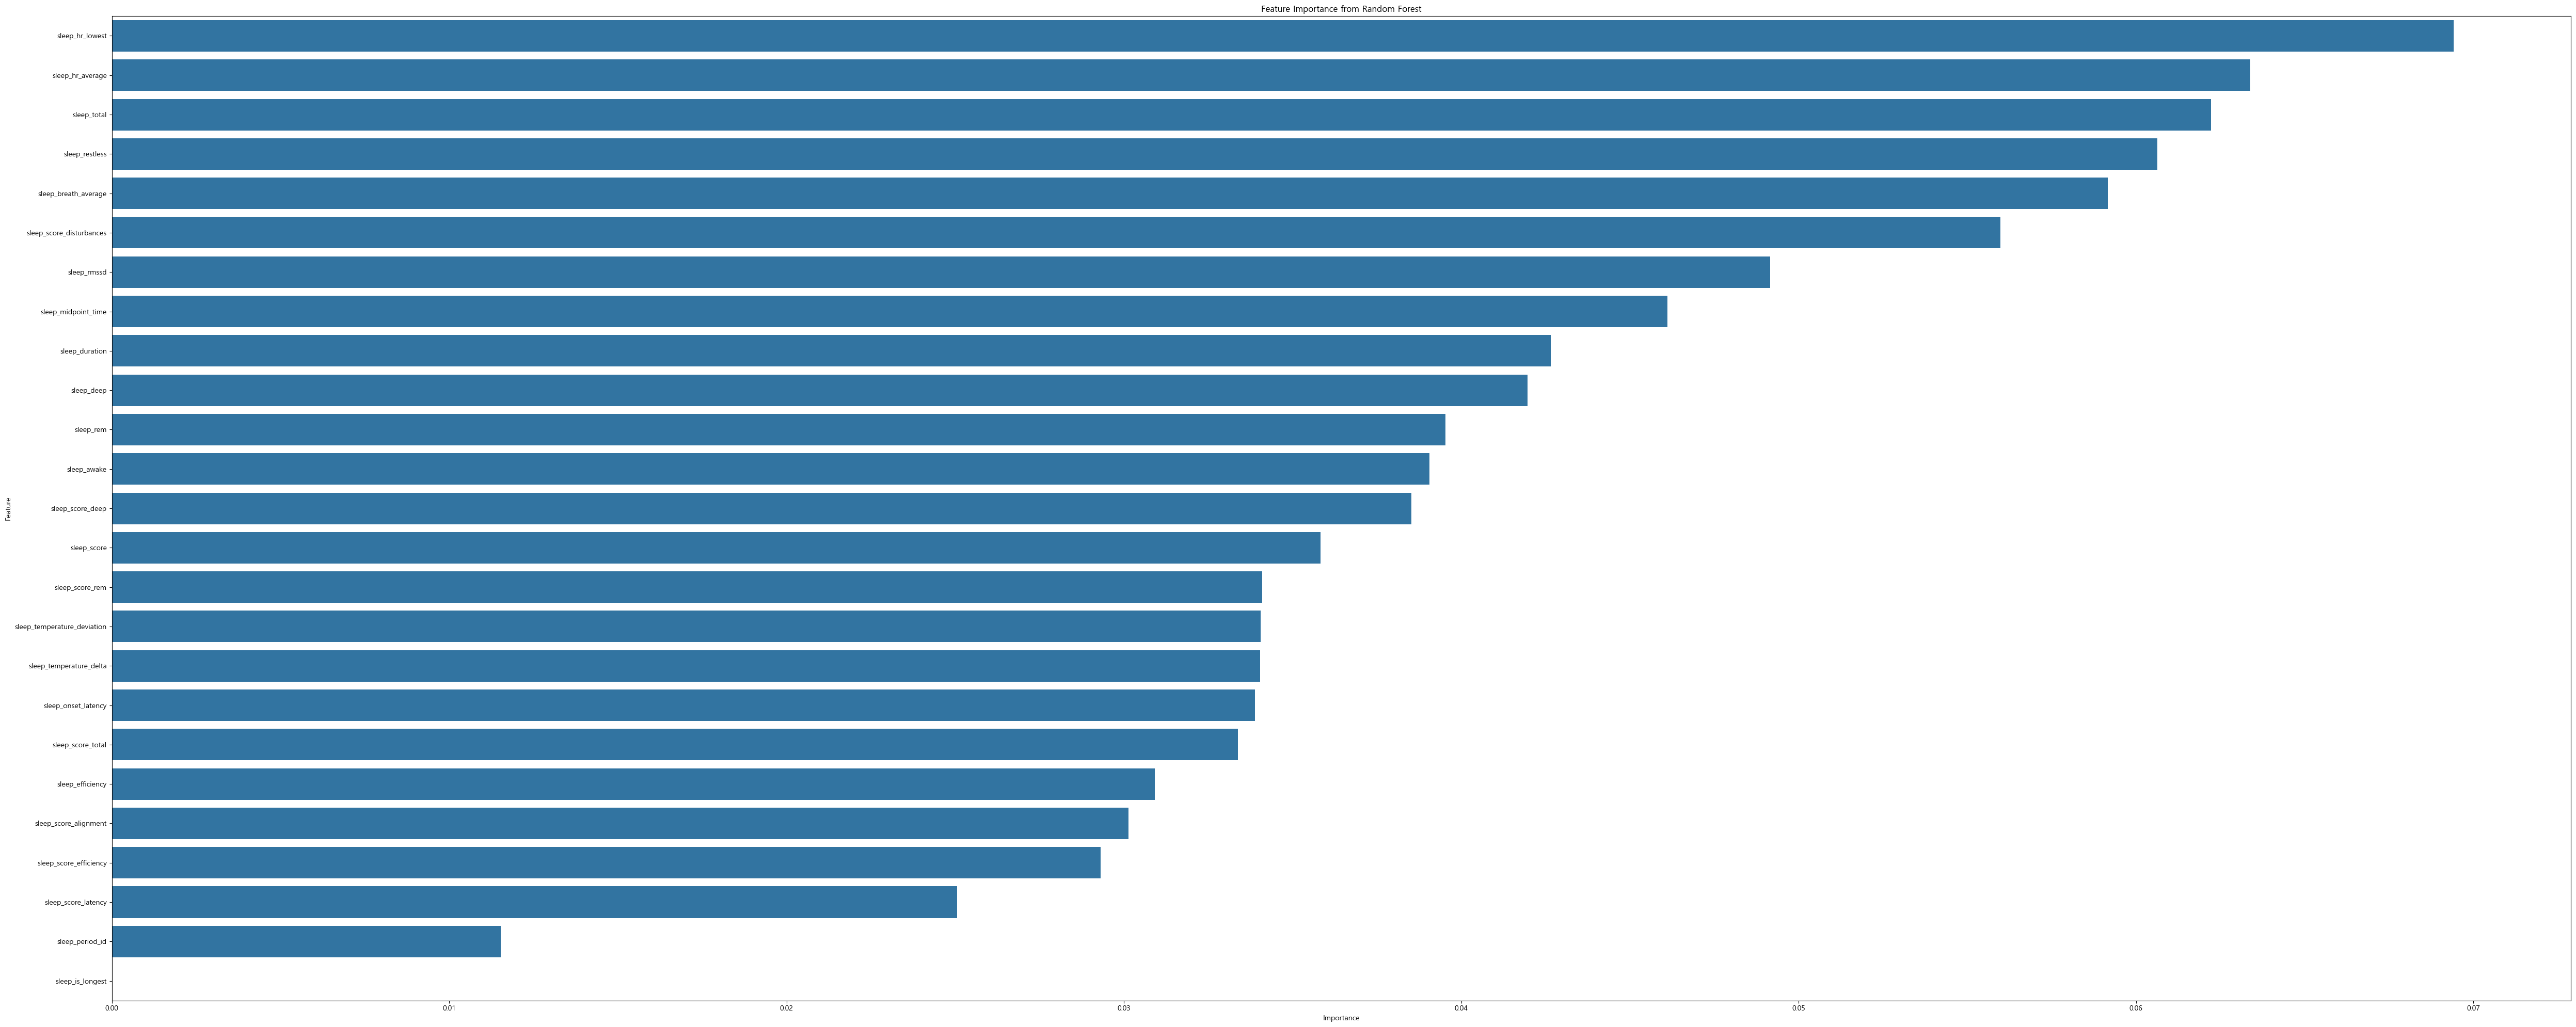

Validation Accuracy: 0.92


In [80]:
# DIAG_NM을 종속 변수로 설정하고 독립 변수와 분리
X_train = train_sleep.drop(columns=['target', 'number'])
y_train = train_sleep['target']

# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# 중요한 피처 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

# 시각화
plt.figure(figsize=(50, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 검증 데이터로 예측 정확도 확인 (선택 사항)
X_val = val_sleep.drop(columns=['target', 'number'])
y_val = val_sleep['target']
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

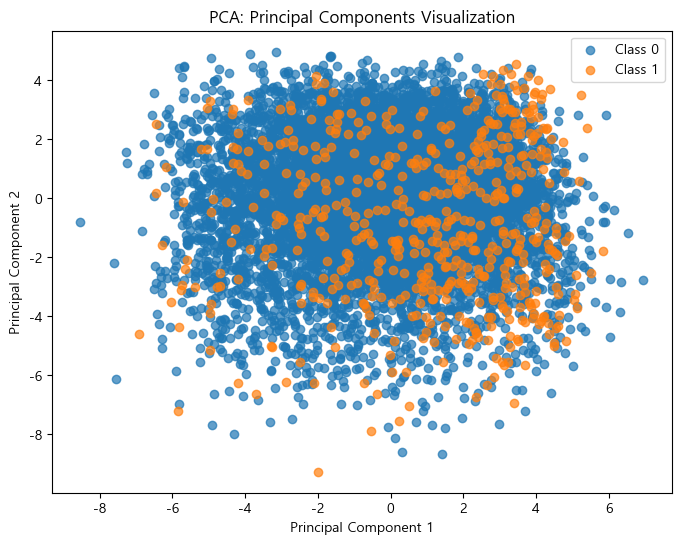

Explained Variance Ratio: [0.23474827 0.18638531]


In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [82]:
top_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_features)

Top 10 Features: ['sleep_hr_lowest', 'sleep_hr_average', 'sleep_total', 'sleep_restless', 'sleep_breath_average', 'sleep_score_disturbances', 'sleep_rmssd', 'sleep_midpoint_time', 'sleep_duration', 'sleep_deep']


In [83]:
X_train = train_sleep[top_features]
y_train = train_sleep["target"]
X_test = val_sleep[top_features]
y_test = val_sleep["target"]

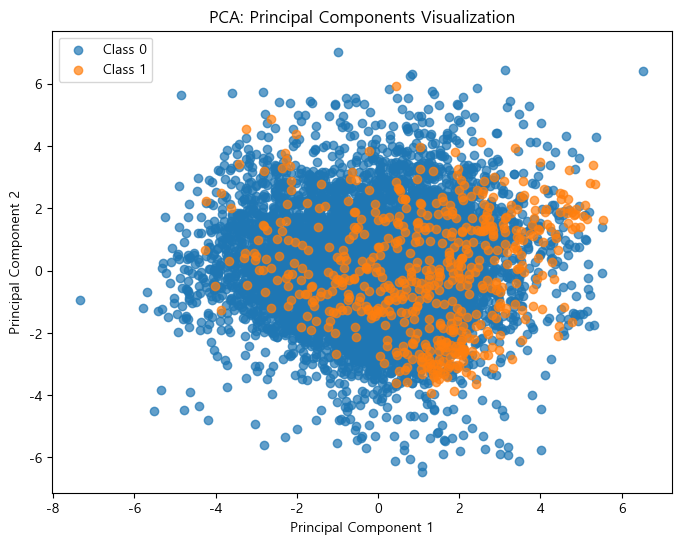

Explained Variance Ratio: [0.28465435 0.26813601]


In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

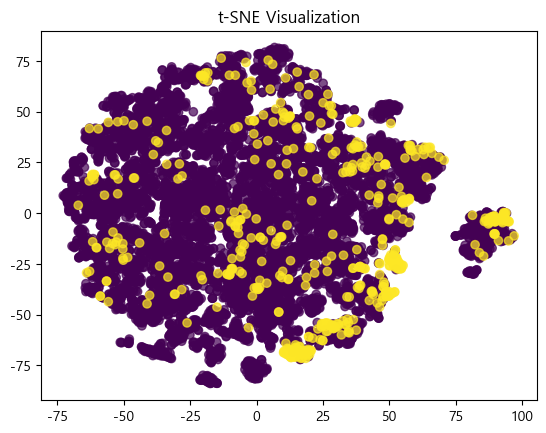

In [44]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.show()

In [85]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.175441
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9694
Method:                           MLE   Df Model:                           10
Date:                Sun, 01 Dec 2024   Pseudo R-squ.:                  0.2159
Time:                        13:04:29   Log-Likelihood:                -1702.7
converged:                       True   LL-Null:                       -2171.5
Covariance Type:            nonrobust   LLR p-value:                4.877e-195
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -8.9267      4.970     -1.796      0.072     -18.667

- 로지스틱 회귀

In [86]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.9136400322841001
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      2264
           1       0.00      0.00      0.00       214

    accuracy                           0.91      2478
   macro avg       0.46      0.50      0.48      2478
weighted avg       0.83      0.91      0.87      2478

Confusion Matrix:
 [[2264    0]
 [ 214    0]]


- 나이브 베이즈

In [87]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 예측
y_pred_nb = nb_model.predict(X_test)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.08635996771589992
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2264
           1       0.09      1.00      0.16       214

    accuracy                           0.09      2478
   macro avg       0.04      0.50      0.08      2478
weighted avg       0.01      0.09      0.01      2478

Confusion Matrix:
 [[   0 2264]
 [   0  214]]


- XGBoost

In [48]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9152542372881356
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      2264
           1       1.00      0.02      0.04       214

    accuracy                           0.92      2478
   macro avg       0.96      0.51      0.50      2478
weighted avg       0.92      0.92      0.88      2478

Confusion Matrix:
 [[2264    0]
 [ 210    4]]


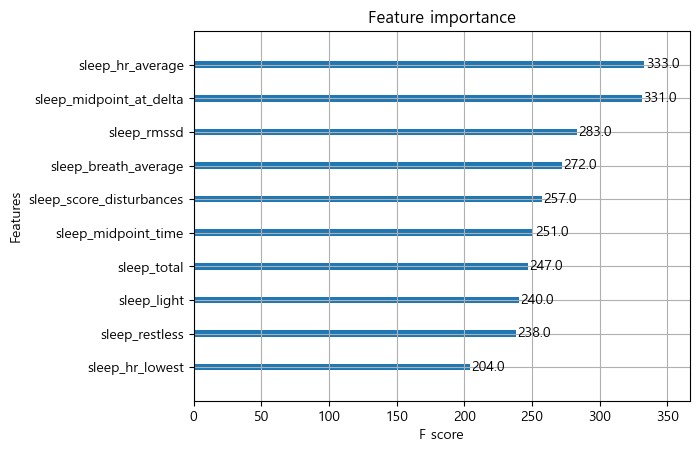

In [49]:
plot_importance(xgb_model)
plt.show()

- LigthGBM

In [50]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=100,learning_rate=0.01, random_state=42, class_weight='balanced')
lgbm_model.fit(X_train, y_train)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 571, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1642
[LightGBM] [Info] Number of data points in the train set: 9705, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.7413236481033091
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84      2264
           1       0.19      0.60      0.29       214

    accuracy                           0.74      2478
   macro avg       0.57      0.68      0.56      2478
weighted avg       0.89      0.74      0.79      2478

Confusion Matrix:
 [[1709  555]
 [  86  128]]


- Decision Tree

In [51]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8490718321226796
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2264
           1       0.11      0.10      0.11       214

    accuracy                           0.85      2478
   macro avg       0.51      0.51      0.51      2478
weighted avg       0.85      0.85      0.85      2478

Confusion Matrix:
 [[2082  182]
 [ 192   22]]


3. activity + sleep으로 학습

                              Feature  Importance
30                    sleep_hr_lowest    0.044646
14                      activity_rest    0.038597
32                        sleep_light    0.037914
21     activity_score_training_volume    0.034849
25               sleep_breath_average    0.033066
29                   sleep_hr_average    0.032892
50                        sleep_total    0.029310
3             activity_daily_movement    0.028700
38                     sleep_restless    0.028306
43           sleep_score_disturbances    0.028031
7                        activity_low    0.026736
37                          sleep_rem    0.026676
11               activity_met_min_low    0.025549
16  activity_score_meet_daily_targets    0.023408
42                   sleep_score_deep    0.023334
34                sleep_midpoint_time    0.022739
33            sleep_midpoint_at_delta    0.022080
39                        sleep_rmssd    0.022016
22                     activity_steps    0.021911


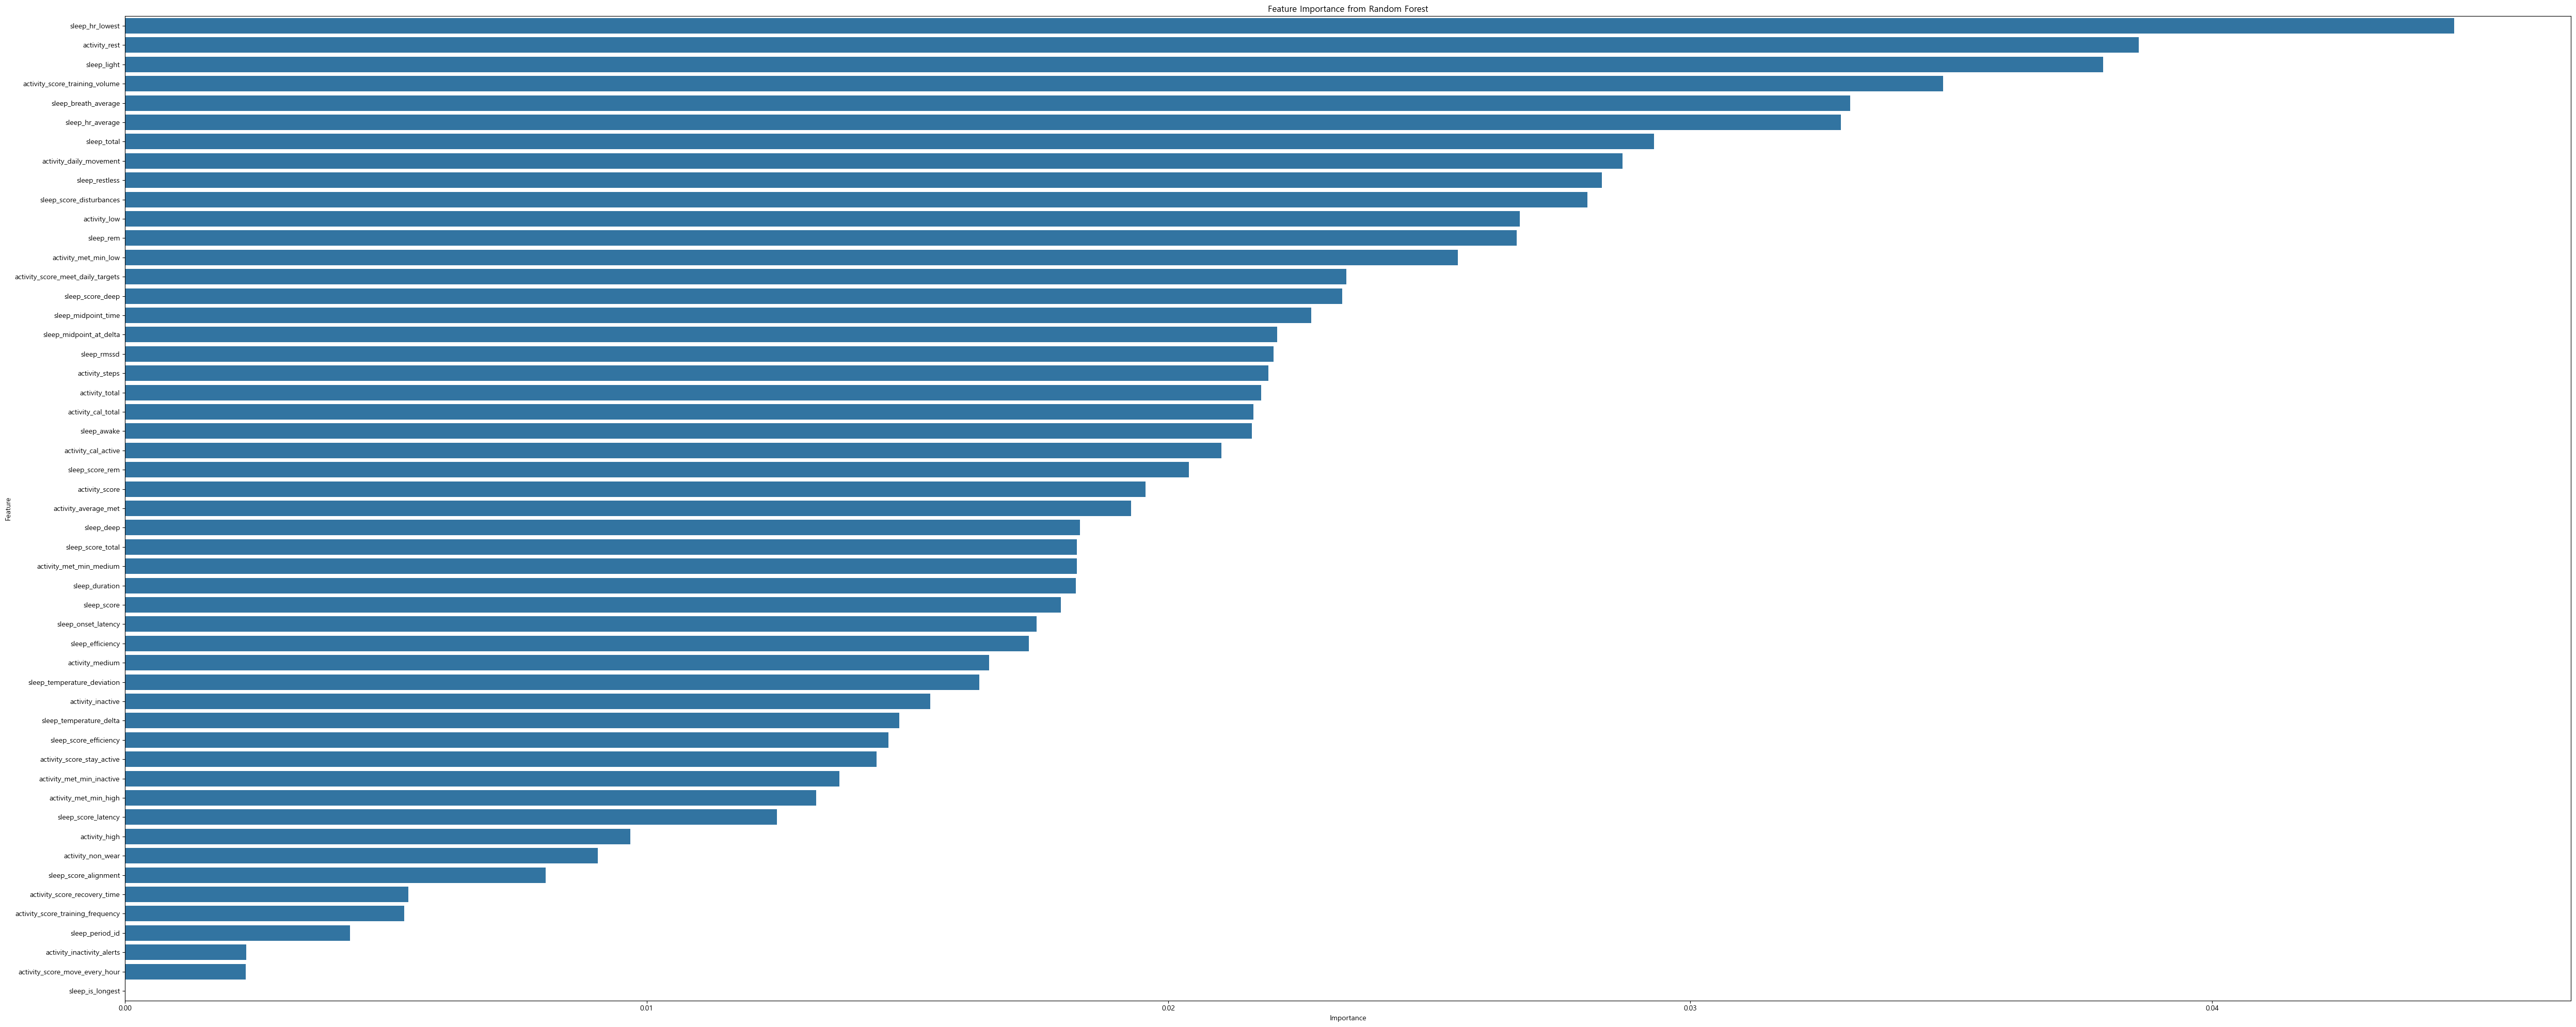

Validation Accuracy: 0.93


In [52]:
# DIAG_NM을 종속 변수로 설정하고 독립 변수와 분리
X_train = train.drop(columns=['target', 'number'])
y_train = train['target']

# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# 중요한 피처 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

# 시각화
plt.figure(figsize=(50, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 검증 데이터로 예측 정확도 확인 (선택 사항)
X_val = test.drop(columns=['target', 'number'])
y_val = test['target']
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

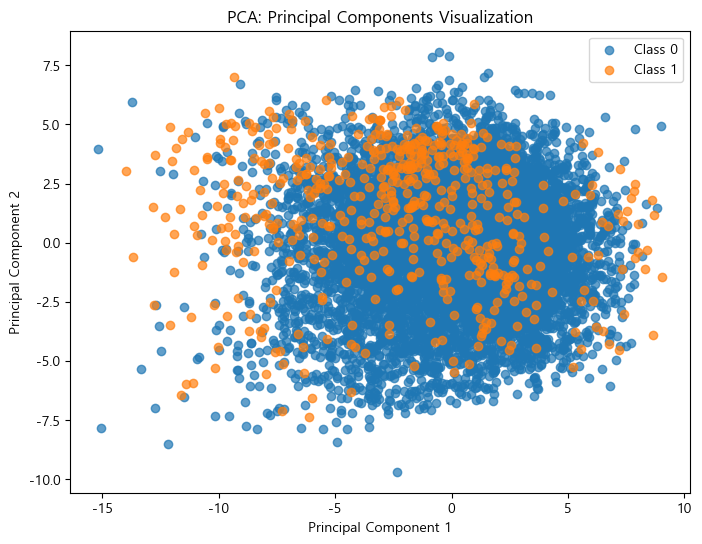

Explained Variance Ratio: [0.2243424  0.13100648]


In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [54]:
top_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_features)

Top 10 Features: ['sleep_hr_lowest', 'activity_rest', 'sleep_light', 'activity_score_training_volume', 'sleep_breath_average', 'sleep_hr_average', 'sleep_total', 'activity_daily_movement', 'sleep_restless', 'sleep_score_disturbances']


In [55]:
X_train = train[top_features]
y_train = train["target"]
X_test = test[top_features]
y_test = test["target"]

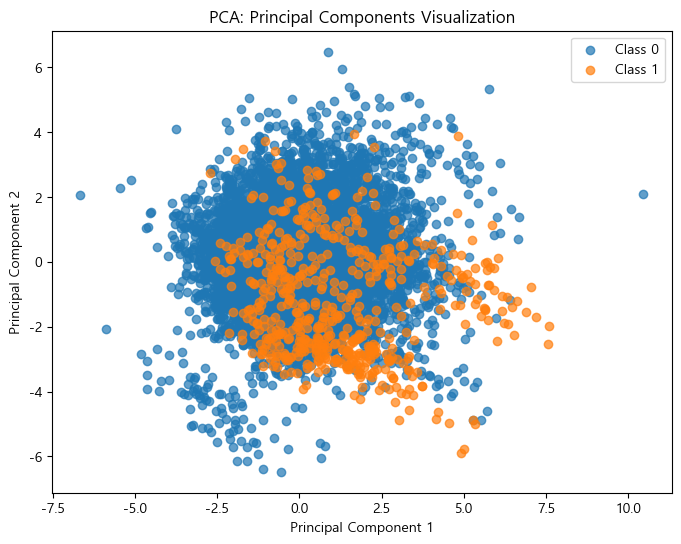

Explained Variance Ratio: [0.2460033  0.21635306]


In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

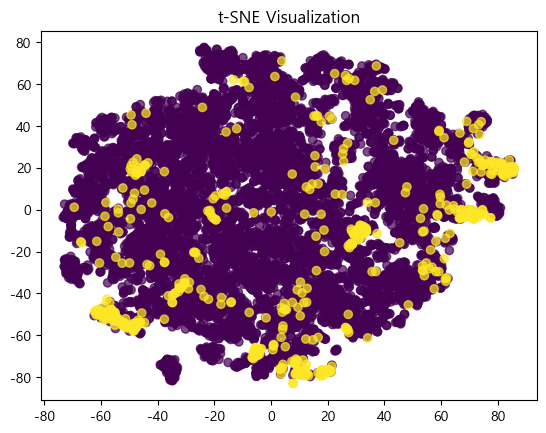

In [57]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.show()

In [58]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.170743
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9694
Method:                           MLE   Df Model:                           10
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.2369
Time:                        22:43:53   Log-Likelihood:                -1657.1
converged:                       True   LL-Null:                       -2171.5
Covariance Type:            nonrobust   LLR p-value:                1.117e-214
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -18.6581      1.835    -10.166     

- 로지스틱 회귀

In [59]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.851089588377724
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      2264
           1       0.35      0.81      0.49       214

    accuracy                           0.85      2478
   macro avg       0.66      0.83      0.70      2478
weighted avg       0.93      0.85      0.88      2478

Confusion Matrix:
 [[1935  329]
 [  40  174]]


- 나이브 베이즈

In [60]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 예측
y_pred_nb = nb_model.predict(X_test)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9572235673930589
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2264
           1       0.83      0.64      0.72       214

    accuracy                           0.96      2478
   macro avg       0.90      0.81      0.85      2478
weighted avg       0.95      0.96      0.95      2478

Confusion Matrix:
 [[2236   28]
 [  78  136]]


- XGBoost

In [61]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9261501210653753
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2264
           1       0.88      0.17      0.28       214

    accuracy                           0.93      2478
   macro avg       0.90      0.58      0.62      2478
weighted avg       0.92      0.93      0.90      2478

Confusion Matrix:
 [[2259    5]
 [ 178   36]]


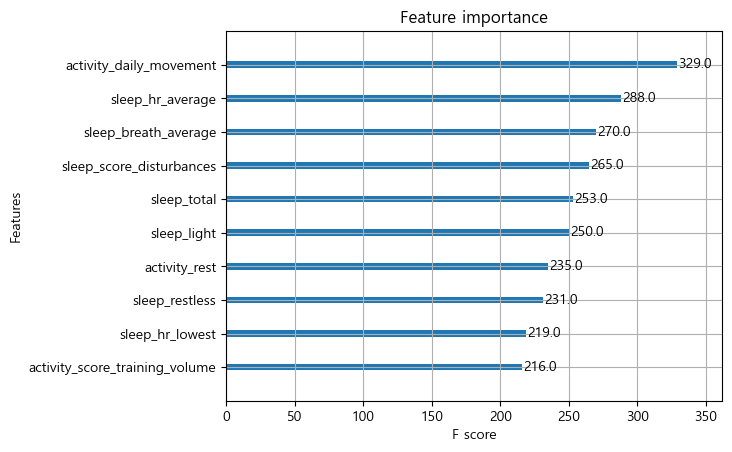

In [62]:
plot_importance(xgb_model)
plt.show()

- LightGBM

In [63]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=200,learning_rate=0.01,random_state=42, class_weight='balanced')
lgbm_model.fit(X_train, y_train)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 571, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 9705, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.927360774818402
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2264
           1       0.58      0.60      0.59       214

    accuracy                           0.93      2478
   macro avg       0.77      0.78      0.77      2478
weighted avg       0.93      0.93      0.93      2478

Confusion Matrix:
 [[2170   94]
 [  86  128]]


- Decision Tree

In [64]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.903954802259887
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      2264
           1       0.25      0.06      0.09       214

    accuracy                           0.90      2478
   macro avg       0.58      0.52      0.52      2478
weighted avg       0.86      0.90      0.88      2478

Confusion Matrix:
 [[2228   36]
 [ 202   12]]


4. activity + sleep + SMOTE적용 으로 학습

In [67]:
# target은 종속 변수 (0/1 값), features는 독립 변수
X_train = train[top_features]
y_train = train["target"]
X_test = test[top_features]
y_test = test["target"]

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (9705, 10) (9705,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (18268, 10) (18268,)
SMOTE 적용 후 레이블 값 분포: 
 target
0    9134
1    9134
Name: count, dtype: int64


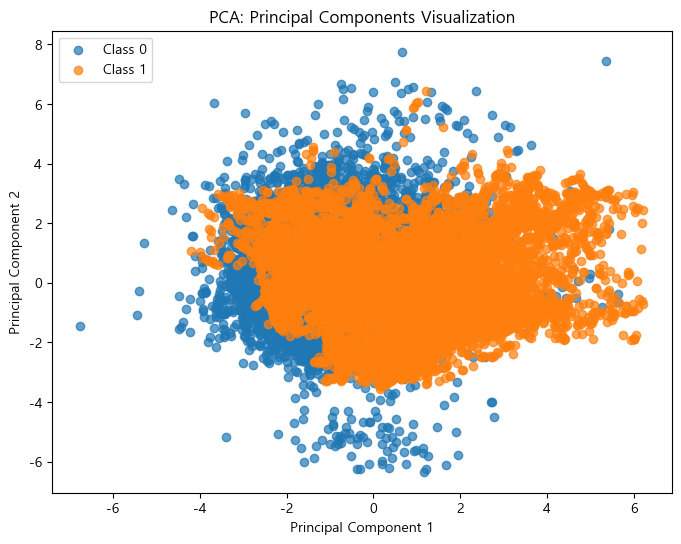

Explained Variance Ratio: [0.30992942 0.24774382]


In [68]:
# SMOTE로 학습된 데이터 (X_train_over, y_train_over)를 표준화
scaler = StandardScaler()
X_train_over_scaled = scaler.fit_transform(X_train_over)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_over_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train_over.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [69]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train_over)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train_over, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.466558
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                18268
Model:                          Logit   Df Residuals:                    18257
Method:                           MLE   Df Model:                           10
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.3269
Time:                        22:44:43   Log-Likelihood:                -8523.1
converged:                       True   LL-Null:                       -12662.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -21.4432      0.745    -28.775     

- 로지스틱 회귀

In [70]:
# 로지스틱 회귀 모델 초기화 및 학습
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train_over, y_train_over)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.8567393058918482
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.92      2264
           1       0.35      0.80      0.49       214

    accuracy                           0.86      2478
   macro avg       0.67      0.83      0.70      2478
weighted avg       0.92      0.86      0.88      2478

Confusion Matrix:
 [[1952  312]
 [  43  171]]


- 나이브 베이즈

In [71]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train_over, y_train_over)

# 예측
y_pred_nb = nb_model.predict(X_test)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8482647296206618
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      2264
           1       0.34      0.81      0.48       214

    accuracy                           0.85      2478
   macro avg       0.66      0.83      0.70      2478
weighted avg       0.92      0.85      0.87      2478

Confusion Matrix:
 [[1928  336]
 [  40  174]]


- XGBoost

In [72]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_over, y_train_over)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9196933010492333
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      2264
           1       0.56      0.35      0.43       214

    accuracy                           0.92      2478
   macro avg       0.75      0.66      0.69      2478
weighted avg       0.91      0.92      0.91      2478

Confusion Matrix:
 [[2204   60]
 [ 139   75]]


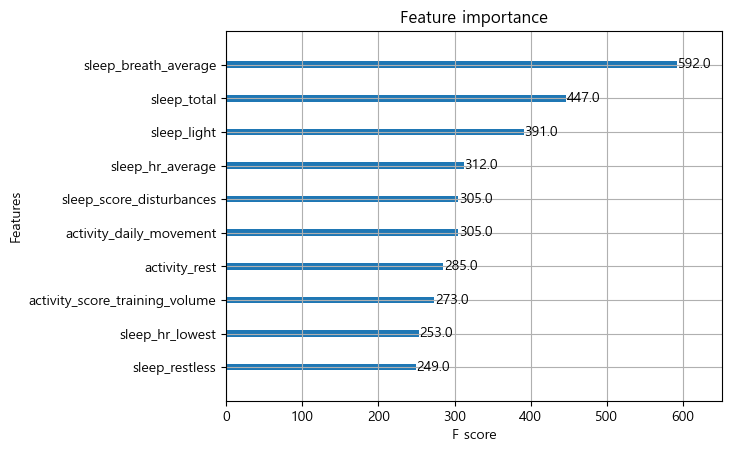

In [73]:
plot_importance(xgb_model)
plt.show()

- LightGBM

In [76]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=50,learning_rate=0.01,random_state=42, class_weight='balanced')
lgbm_model.fit(X_train_over, y_train_over)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 9134, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 18268, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.8696529459241323
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      2264
           1       0.36      0.66      0.47       214

    accuracy                           0.87      2478
   macro avg       0.66      0.77      0.70      2478
weighted avg       0.91      0.87      0.89      2478

Confusion Matrix:
 [[2014  250]
 [  73  141]]


- Decision Tree

In [ ]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(splitter='random',random_state=42, class_weight='balanced')
dt_model.fit(X_train_over, y_train_over)

# 예측
y_pred_dt = dt_model.predict(X_test)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8523002421307506
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      2264
           1       0.21      0.27      0.24       214

    accuracy                           0.85      2478
   macro avg       0.57      0.59      0.58      2478
weighted avg       0.87      0.85      0.86      2478

Confusion Matrix:
 [[2055  209]
 [ 157   57]]


5. activity + sleep + BorderlineSMOTE적용 으로 학습

In [78]:
# Borderline-SMOTE 적용
borderline_smote = BorderlineSMOTE(kind='borderline-1', random_state=42)
X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)

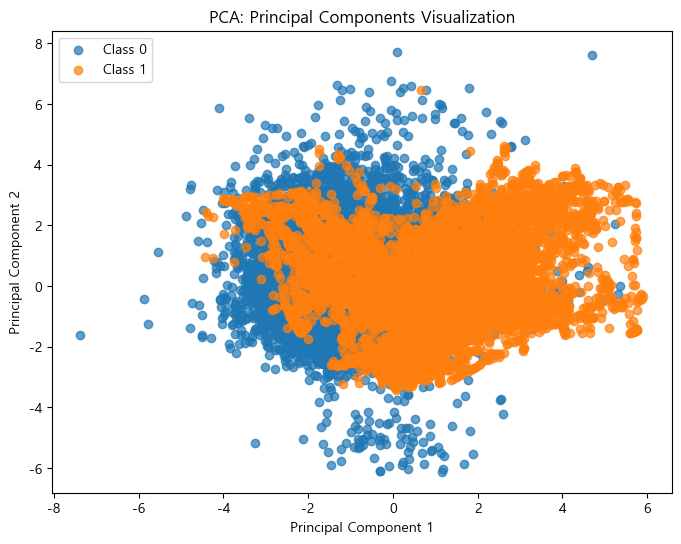

Explained Variance Ratio: [0.32291061 0.25033489]


In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_resampled.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

- 로지스틱 회귀

In [80]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_resampled)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_resampled, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.392789
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                18268
Model:                          Logit   Df Residuals:                    18257
Method:                           MLE   Df Model:                           10
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.4333
Time:                        22:46:14   Log-Likelihood:                -7175.5
converged:                       True   LL-Null:                       -12662.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -25.9380      0.898    -28.876     

In [81]:
# 로지스틱 회귀 모델 초기화 및 학습
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_resampled, y_resampled)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.8813559322033898
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      2264
           1       0.40      0.78      0.53       214

    accuracy                           0.88      2478
   macro avg       0.69      0.84      0.73      2478
weighted avg       0.93      0.88      0.90      2478

Confusion Matrix:
 [[2017  247]
 [  47  167]]


- 나이브 베이즈

In [82]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)

# 예측
y_pred_nb = nb_model.predict(X_test)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8676351896690879
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.92      2264
           1       0.37      0.78      0.50       214

    accuracy                           0.87      2478
   macro avg       0.67      0.83      0.71      2478
weighted avg       0.92      0.87      0.89      2478

Confusion Matrix:
 [[1983  281]
 [  47  167]]


- XGBoost

In [83]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9265536723163842
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2264
           1       0.65      0.32      0.43       214

    accuracy                           0.93      2478
   macro avg       0.79      0.65      0.70      2478
weighted avg       0.91      0.93      0.92      2478

Confusion Matrix:
 [[2227   37]
 [ 145   69]]


- LightGBM

In [87]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=50,learning_rate=0.1,random_state=42, class_weight='balanced')
lgbm_model.fit(X_resampled, y_resampled)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 9134, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 18268, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.927360774818402
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      2264
           1       0.61      0.44      0.51       214

    accuracy                           0.93      2478
   macro avg       0.78      0.71      0.74      2478
weighted avg       0.92      0.93      0.92      2478

Confusion Matrix:
 [[2203   61]
 [ 119   95]]


- Decision Tree

In [90]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(criterion="entropy",splitter='random',random_state=42, class_weight='balanced')
dt_model.fit(X_resampled, y_resampled)

# 예측
y_pred_dt = dt_model.predict(X_test)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8829701372074253
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      2264
           1       0.34      0.37      0.35       214

    accuracy                           0.88      2478
   macro avg       0.64      0.65      0.64      2478
weighted avg       0.89      0.88      0.89      2478

Confusion Matrix:
 [[2109  155]
 [ 135   79]]
